In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import re

import spacy
from spacy.matcher import Matcher

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

# Null Values

In [3]:
raw_df = pd.read_csv('dog_supplement_clean.csv')
raw_df.head()

,name,date,title,rating,review,country,sentiment
0,Blayne,2023-02-17,please avoid,1.0,you try to do right by your dog by getting the...,United States,negative
1,Jake Morrison,2023-02-17,dog was allergic to these,1.0,i have an 80lb weimaraner and started him off ...,United States,negative
2,le’MamaAmazon Customer,2021-02-01,these made my dog sick,1.0,poor little guy apparently i have one of those...,United States,negative
3,Captain,2023-03-04,12 yo italian grey hound very sick,1.0,i have two dogs and my boxer mix doesnt seem t...,United States,negative
4,Dio I,2022-05-28,not for every dog,1.0,i wanted to take my time before i write this n...,United States,negative


In [4]:
# check shape
raw_df.shape

(3987, 7)

In [5]:
# check for missing values
raw_df.isna().sum()

name         0
date         0
title        3
rating       0
review       2
country      0
sentiment    0
dtype: int64

In [6]:
# check for missing title
pd.set_option('max_colwidth', None)
raw_df[raw_df['title'].isna()]

,name,date,title,rating,review,country,sentiment
421,Pam,2022-01-22,NaN,1.0,i couldnt get my dog to eat them she is very picky,United States,negative
517,Dave,2021-05-07,NaN,1.0,seal was broken this time bad itemim not giving this to my dogi need no more from this company,United States,negative
1454,Amazon Customer,2022-07-24,NaN,5.0,my dog is getting old she was sleeping a lot not very active i started giving her these senior advanced treats and shes getting her toys out to play again getting more active and seems like shes feeling much better,United States,positive


In [7]:
# there's only two so I can read them and shorten them to make titles for these rows.
# can probably remove the positive sentiment row
raw_df.loc[421, 'title'] = 'dog wont eat'
raw_df.loc[517, 'title'] = 'bad item seal was broken'

# drop positive missing title row
raw_df = raw_df.dropna(subset='title')

In [8]:
# check missing value
raw_df.isna().sum()

name         0
date         0
title        0
rating       0
review       2
country      0
sentiment    0
dtype: int64

In [9]:
# check for missing reviews
raw_df[raw_df['review'].isna()]

# both are positive reviews can probably drop them

,name,date,title,rating,review,country,sentiment
1327,Amazon Customer,2022-11-17,keeps my little one healthy and happy,5.0,NaN,United States,positive
2077,Melissa H.,2022-06-30,great product,5.0,NaN,United States,positive


In [10]:
# if web scraping is run properly
# check if there are any negative sentiment within the missing reviews.
#raw_df[(raw_df['review'].isna()) & (raw_df['sentiment'] == 'negative')]

In [11]:
# getting the index of missing reviews
drop_index = raw_df[raw_df['review'].isna()].index

# dropping the missing reviews
raw_df = raw_df.drop(drop_index)

In [12]:
raw_df.shape

(3984, 7)

In [13]:
# check for null values
raw_df.isna().sum()

name         0
date         0
title        0
rating       0
review       0
country      0
sentiment    0
dtype: int64

In [14]:
raw_df.dtypes

name          object
date          object
title         object
rating       float64
review        object
country       object
sentiment     object
dtype: object

In [24]:
# to csv file
#raw_df.to_csv('dog_supplement_no_na.csv', index=False)

# Time Series Graph

In [19]:
pd.reset_option('max_colwidth')

# take out just the date and sentiment columns
date_df = pd.DataFrame(raw_df[['sentiment', 'date']])

# change the sentiment to binary
date_df = pd.get_dummies(date_df, columns=['sentiment'], drop_first=True)

date_df.head()

,date,sentiment_positive
0,2023-02-17,0
1,2023-02-17,0
2,2021-02-01,0
3,2023-03-04,0
4,2022-05-28,0


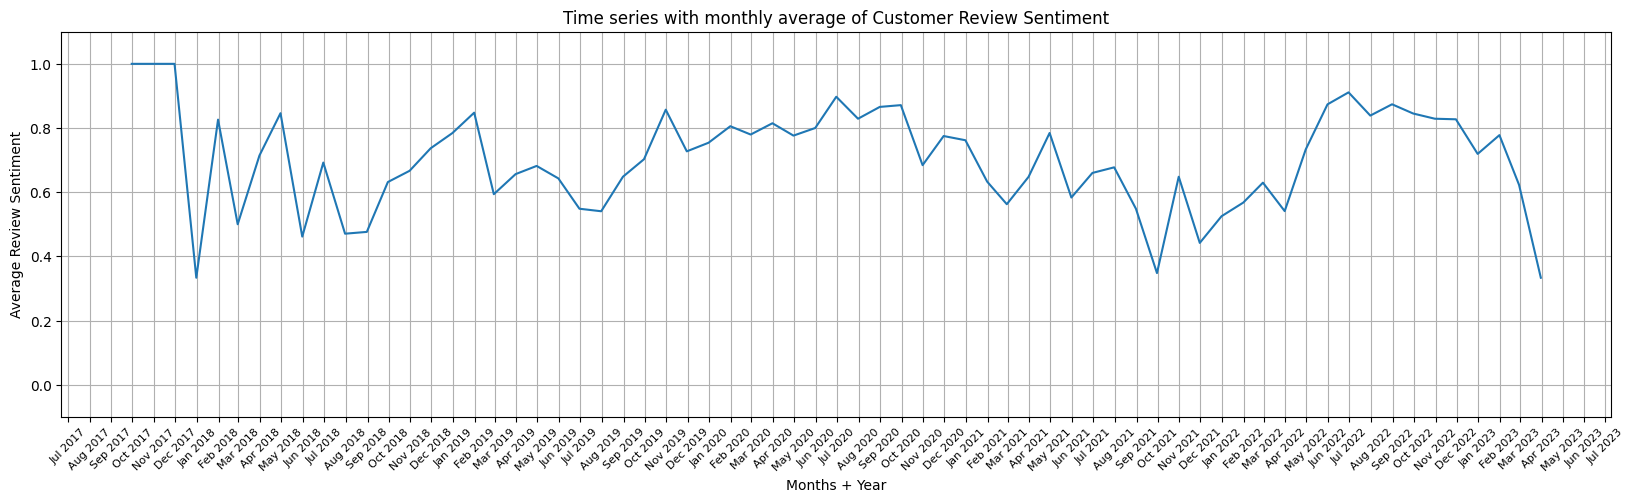

In [22]:
# change date column to datetime
date_df['date'] = pd.to_datetime(date_df['date'])

# group data by month and calculate mean of sentiment column
monthly_mean = date_df.groupby(pd.Grouper(key='date', freq='M')).mean().reset_index()

# create plot
fig, ax = plt.subplots(figsize = (20, 5))
time_series = plt.plot(monthly_mean['date'], monthly_mean['sentiment_positive'])

# set ylimit between 0 and 1
plt.ylim(-0.1, 1.1)

# Label graph
ax.set_xlabel('Months + Year')
ax.set_ylabel('Average Review Sentiment')
ax.set_title('Time series with monthly average of Customer Review Sentiment')

# format x-axis ticks and labels
months = mdates.MonthLocator()  # every month
years = mdates.YearLocator()  # every year
date_fmt = mdates.DateFormatter('%b %Y')  # month name and year
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)
plt.xticks(rotation=45, fontsize=8)

# show grid lines
ax.grid(True)

plt.show()

# save the pair plot as a PNG file
fig.savefig("time_series.png")

- The reviews are quite even through out the months and years

# Cleaning Text

In [15]:
# create function remove commonly used words from review

def clean_text(text):
    # tokenize the text into words
    word_tokens = word_tokenize(text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in word_tokens if not word.lower() in stop_words]
    
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    # re-join the lemmatized words into text
    clean_text = ' '.join(lemmatized_words)
    
    return clean_text

In [16]:
# apply the clean_text function to the 'review' column of the DataFrame
raw_df['clean_title'] = raw_df['title'].apply(clean_text)
raw_df['clean_review'] = raw_df['review'].apply(clean_text)

In [17]:
# concatenate the cleaned review and title into a single column
raw_df['total_text'] = raw_df['clean_title'] + ' ' + raw_df['clean_review']

In [23]:
# check df
raw_df.head()

,name,date,title,rating,review,country,sentiment,clean_title,clean_review,total_text
0,Blayne,2023-02-17,please avoid,1.0,you try to do right by your dog by getting the...,United States,negative,please avoid,try right dog getting vitamin happens made 15 ...,please avoid try right dog getting vitamin hap...
1,Jake Morrison,2023-02-17,dog was allergic to these,1.0,i have an 80lb weimaraner and started him off ...,United States,negative,dog allergic,80lb weimaraner started recommended dose loved...,dog allergic 80lb weimaraner started recommend...
2,le’MamaAmazon Customer,2021-02-01,these made my dog sick,1.0,poor little guy apparently i have one of those...,United States,negative,made dog sick,poor little guy apparently one ridiculously se...,made dog sick poor little guy apparently one r...
3,Captain,2023-03-04,12 yo italian grey hound very sick,1.0,i have two dogs and my boxer mix doesnt seem t...,United States,negative,12 yo italian grey hound sick,two dog boxer mix doesnt seem affected however...,12 yo italian grey hound sick two dog boxer mi...
4,Dio I,2022-05-28,not for every dog,1.0,i wanted to take my time before i write this n...,United States,negative,every dog,wanted take time write negative review mainly ...,every dog wanted take time write negative revi...


## Word Cloud

In [74]:
# shorten the df name
df = raw_df

In [75]:
# separate text data by sentiment
positive_text = ' '.join(df[df['sentiment'] == 'positive']['total_text'].dropna().astype(str).tolist())
negative_text = ' '.join(df[df['sentiment'] == 'negative']['total_text'].dropna().astype(str).tolist())

# create word clouds
positive_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(negative_text)

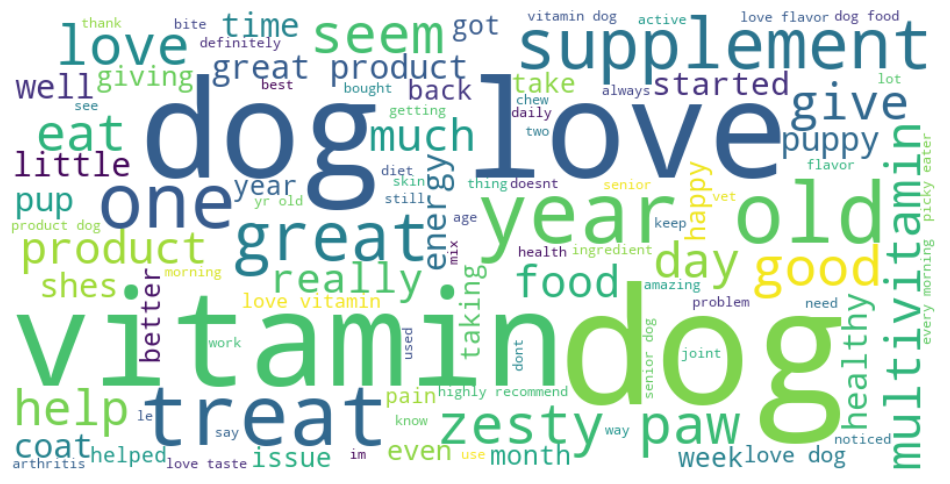

In [76]:
# display the word cloud with positive sentiment
plt.figure(figsize=(12,8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

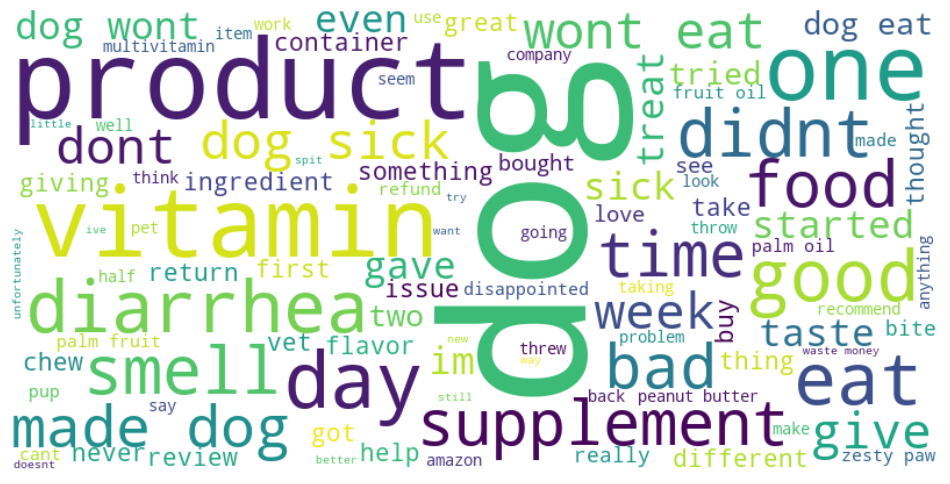

In [77]:
# display the word cloud with negative sentiment
plt.figure(figsize=(12,8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# a lot of common words are used in both sentiment
# I should remove them to get a more selected word list

In [78]:
# remove same words from both word clouds
positive_words = set(positive_wordcloud.words_)
negative_words = set(negative_wordcloud.words_)
common_words = positive_words.intersection(negative_words)

# create word clouds without the common words
p_wordcloud_removed = WordCloud(width=800, height=400, max_words=100, background_color='white', stopwords=common_words).generate(positive_text)
n_wordcloud_removed = WordCloud(width=800, height=400, max_words=100, background_color='white', stopwords=common_words).generate(negative_text)

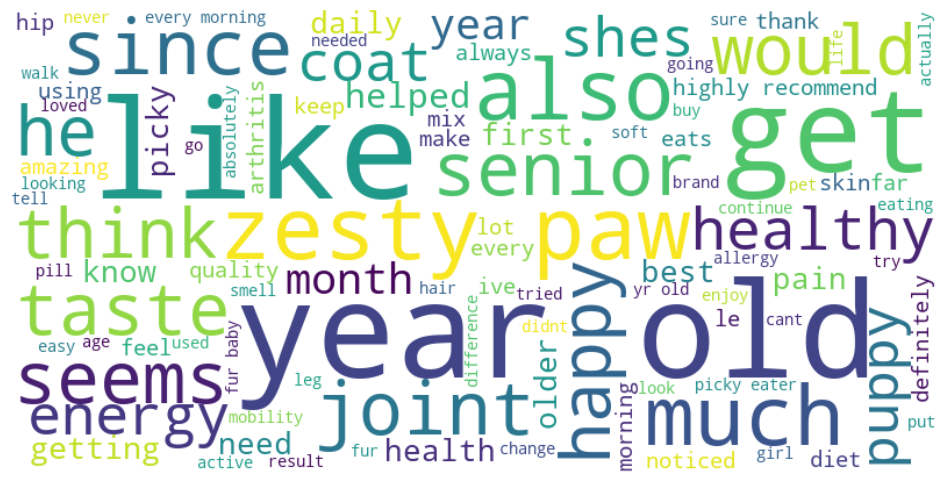

In [79]:
# display the word cloud with positive sentiment and common words removed
plt.figure(figsize=(12,8))
plt.imshow(p_wordcloud_removed, interpolation='bilinear')
plt.axis('off')
plt.show()

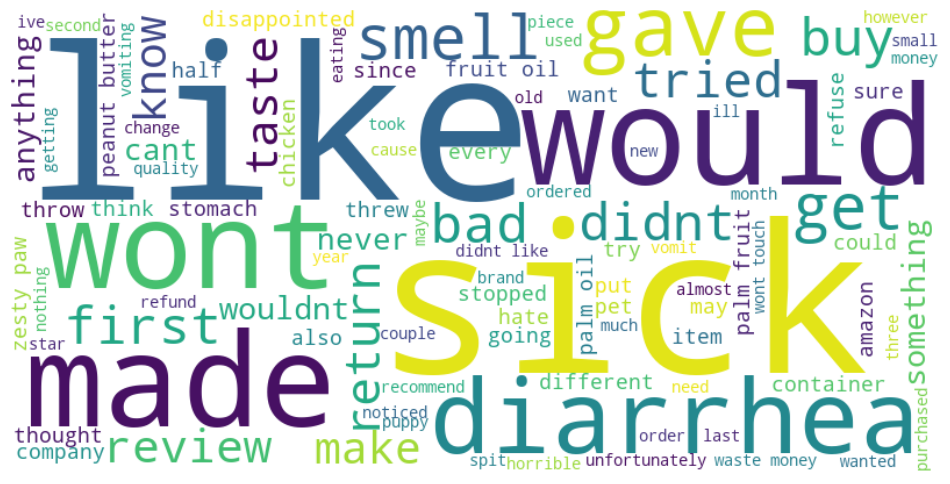

In [80]:
# display the word cloud with negative sentiment and common words removed
plt.figure(figsize=(12,8))
plt.imshow(n_wordcloud_removed, interpolation='bilinear')
plt.axis('off')
plt.show()

## Sentiment Modelling
- creating a model to test for positive/negative sentiment in order to filter through the 3 star reviews which some have positive sentiment and some have negative sentiment.

In [81]:
# finding similar synonyms for words in word lists
def get_synonyms(word_list):
    l = []
    for word in word_list:
        l.extend(list(set([y for x in [[y.name() for y in x.lemmas()] for x in wordnet.synsets(word)] for y in x])))
    return(list(set(l)))

In [82]:
# words from wordcloud
p_words = ['like', 'energy', 'daily', 'healthy', 'recommend', 'quality', 'happy', 'good']
n_words = ['horrible', 'sick', 'bad', 'refund', 'diarrhea', 'allergic', 'disappointed', 'refuse', 'avoid']

# extend wordlists using get synonyms function
p_wordlist = p_words + get_synonyms(p_words)
n_wordlist = p_words + get_synonyms(n_words)

In [83]:
# remove underscore from list of words
positive_words = [word.replace('_', '') for word in p_wordlist]
negative_words = [word.replace('_', '') for word in n_wordlist]

In [84]:
# define a function to append scores to review

def get_sentiment(sentence):
    # sentiment_score = 0 in the beginning
    sentiment_score = 0
    
    # check if any positive words appear in the sentence 
    for word in positive_words:
        if word in sentence:
            # if word is positive plus 1
            sentiment_score += 1
    
    # check if any negative words appear in the sentence
    for word in negative_words:
        if word in sentence:
            # if word is negative minus 1
            sentiment_score -= 1
    
    # assign sentiment based on overall score
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

In [85]:
# applying the get_sentiment function to title and review
df['pred_sentiment'] = df['total_text'].apply(lambda x: get_sentiment(x))

In [87]:
df.head()

,name,date,title,rating,review,country,sentiment,clean_title,clean_review,total_text,pred_sentiment
0,Blayne,2023-02-17,please avoid,1.0,you try to do right by your dog by getting the...,United States,negative,please avoid,try right dog getting vitamin happens made 15 ...,please avoid try right dog getting vitamin hap...,negative
1,Jake Morrison,2023-02-17,dog was allergic to these,1.0,i have an 80lb weimaraner and started him off ...,United States,negative,dog allergic,80lb weimaraner started recommended dose loved...,dog allergic 80lb weimaraner started recommend...,positive
2,le’MamaAmazon Customer,2021-02-01,these made my dog sick,1.0,poor little guy apparently i have one of those...,United States,negative,made dog sick,poor little guy apparently one ridiculously se...,made dog sick poor little guy apparently one r...,neutral
3,Captain,2023-03-04,12 yo italian grey hound very sick,1.0,i have two dogs and my boxer mix doesnt seem t...,United States,negative,12 yo italian grey hound sick,two dog boxer mix doesnt seem affected however...,12 yo italian grey hound sick two dog boxer mi...,negative
4,Dio I,2022-05-28,not for every dog,1.0,i wanted to take my time before i write this n...,United States,negative,every dog,wanted take time write negative review mainly ...,every dog wanted take time write negative revi...,positive


In [88]:
# function for testing the accuracy score
def scorer(true_col, pred_col):
    print(f"Accuracy Score: {sum(raw_df[true_col] == raw_df[pred_col])/len(raw_df):.2%}")
    
# testing accuracy
scorer('sentiment', 'pred_sentiment')

Accuracy Score: 56.48%


In [89]:
# function for seeing how many positive/negative were correct
def get_matrix(true_col, pred_col):
    tp_sum = 0
    fp_sum = 0
    tn_sum = 0
    fn_sum = 0
    neutral = 0
    
    for true, pred in zip(raw_df[true_col], raw_df[pred_col]):
        if true == 'positive' and pred == 'positive':
            tp_sum += 1
        elif true == 'negative' and pred == 'negative':
            tn_sum += 1
        elif true == 'positive' and pred == 'negative':
            fn_sum += 1
        elif true == 'negative' and pred == 'positive':
            fp_sum += 1
        else: 
            neutral += 1
    print('       Positive | Negative')
    print(f'True:       {tp_sum} | {tn_sum}')
    print(f'False:       {fp_sum}| {fn_sum}')
    print()
    print(f'Neutral: {neutral}')
    
# test for 
get_matrix('sentiment', 'pred_sentiment')

# Lot of false positive reviews, maybe some keywords were being picked up?

       Positive | Negative
True:       1792 | 458
False:       263| 241

Neutral: 1230


- Results are not too bad for positive reviews, but only half of the negative ones are right.
- This might be because they tend to write more for positive reviews, hence have more words to match.